# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация

Дата выдачи: 02.02.2024

Мягкий дедлайн: 23:59MSK 19.02.2024

Жесткий дедлайн: 23:59MSK 25.02.2024

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

!pip install keras

!pip install tensorflow

In [49]:
from sklearn.metrics import accuracy_score
import keras
from keras.datasets import fashion_mnist
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler, Normalizer
import scipy.spatial
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV


In [38]:
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(y_train.shape[0], -1)
x_test = x_test_pics.reshape(y_test.shape[0], -1)

__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [39]:
class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """
        Implements a pipeline which consists of PCA decomposition,
        Random Fourier Features approximation and a linear classification model.
        
        Parameters:
        n_features (int): Number of synthetic random features generated with RFF approximation.
        new_dim (int): Output size of the PCA.
        use_PCA (bool): Whether to include PCA preprocessing.
        classifier (str): Type of linear classification model ('svm' or 'logreg').
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier_type = classifier
        self.scale = StandardScaler()
        self.normalize = Normalizer()
        self.model_pca = None
        self.sigma = None
        self.weights = None
        self.bias = None
        self.classifier = None

    def fit(self, X, y):
        """
        Fit all parts of the algorithm (PCA, RFF, Classification) to the training set.
        """
        X_scaled = self.scale.fit_transform(X)
        X_normalized = self.normalize.fit_transform(X_scaled)

        if self.use_PCA:
            self.model_pca = PCA(n_components=self.new_dim)
            X_pca = self.model_pca.fit_transform(X_normalized)
        else:
            X_pca = X_normalized

        sample_size = min(X_pca.shape[0], 1000)
        indices1 = np.random.choice(X_pca.shape[0], size=sample_size, replace=False)
        indices2 = np.random.choice(X_pca.shape[0], size=sample_size, replace=False)
        valid_indices = indices1 != indices2
        self.sigma = np.median(np.sum((X_pca[indices1[valid_indices]] - X_pca[indices2[valid_indices]])**2, axis=1)) ** 0.5


        self.weights = np.random.normal(0, 1 / self.sigma, (self.new_dim if self.use_PCA else X_pca.shape[1], self.n_features))
        self.bias = np.random.uniform(-np.pi, np.pi, self.n_features)

        X_transformed = self.transform(X)  
        if self.classifier_type == 'logreg':
            self.classifier = LogisticRegression(max_iter=10000)
        elif self.classifier_type == 'svm':
            self.classifier = LinearSVC(max_iter=10000)
        else:
            raise ValueError("Classifier must be 'logreg' or 'svm'")
        self.classifier.fit(X_transformed, y)

        return self

    def transform(self, X):
        """
        Apply preprocessing, PCA and RFF transformation to the data.
        """
        X_scaled = self.scale.transform(X)
        X_normalized = self.normalize.transform(X_scaled)
        if self.use_PCA:
            X_pca = self.model_pca.transform(X_normalized)
        else:
            X_pca = X_normalized
        X_rff = np.cos(np.dot(X_pca, self.weights) + self.bias)
        return X_rff

    def predict_proba(self, X):
        """
        Apply the pipeline to obtain scores for input data.
        """
        if self.classifier_type != 'logreg':
            raise ValueError("Probability estimates are only available for logistic regression.")
        X_transformed = self.transform(X)
        return self.classifier.predict_proba(X_transformed)

    def predict(self, X):
        """
        Apply the pipeline to obtain discrete predictions for input data.
        """
        X_transformed = self.transform(X)
        return self.classifier.predict(X_transformed)


In [40]:
subset_idx = np.random.choice(np.arange(x_train.shape[0]), 10000, replace=False)

In [41]:
rff_pipeline = RFFPipeline(n_features=1000, new_dim=50, use_PCA=True, classifier='logreg')
rff_pipeline.fit(x_train[subset_idx], y_train[subset_idx])


y_pred = rff_pipeline.predict(x_test)
accuracy_score(y_test, y_pred)


0.8542

__Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

### Linear SVM

In [42]:
%%time
linear_svm = SVC(kernel='linear')
linear_svm.fit(x_train[subset_idx], y_train[subset_idx])

CPU times: user 16.2 s, sys: 87.6 ms, total: 16.3 s
Wall time: 16.4 s


SVC(kernel='linear')

In [43]:
%%time
y_pred_linear = linear_svm.predict(x_test)
accuracy_score(y_test, y_pred_linear)

CPU times: user 13.7 s, sys: 62.9 ms, total: 13.7 s
Wall time: 13.8 s


0.792

### Kernel SVM

In [44]:
%%time
kernel_svm = SVC(kernel='rbf')
kernel_svm.fit(x_train[subset_idx], y_train[subset_idx]) 

CPU times: user 10 s, sys: 62.2 ms, total: 10.1 s
Wall time: 10.1 s


SVC()

In [45]:
%%time
y_pred_kernel = kernel_svm.predict(x_test)
accuracy_score(y_test, y_pred_kernel)


CPU times: user 24.4 s, sys: 162 ms, total: 24.5 s
Wall time: 24.8 s


0.8545

### RFFP

In [46]:
%%time
rff_pipeline = RFFPipeline(n_features=1000, new_dim=50, use_PCA=True, classifier='logreg')
rff_pipeline.fit(x_train[subset_idx], y_train[subset_idx])


CPU times: user 12min 41s, sys: 2min 53s, total: 15min 35s
Wall time: 2min 21s


RFFPipeline(classifier=LogisticRegression(max_iter=10000))

In [47]:
%%time
y_pred = rff_pipeline.predict(x_test)
accuracy_score(y_test, y_pred)

CPU times: user 845 ms, sys: 318 ms, total: 1.16 s
Wall time: 336 ms


0.8578

### PCA + boosting

In [35]:
%%time
pca = PCA(n_components=50)
x_train_pca = pca.fit_transform(x_train[subset_idx])
x_test_pca = pca.transform(x_test)

# Обучение XGBoost
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1)
xgb_model.fit(x_train_pca, y_train[subset_idx])



CPU times: user 27.7 s, sys: 1.55 s, total: 29.2 s
Wall time: 4.04 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [36]:
%%time
y_pred_xgb = xgb_model.predict(x_test_pca)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
accuracy_xgb

CPU times: user 319 ms, sys: 5.04 ms, total: 324 ms
Wall time: 51.6 ms


0.8346

In [50]:
%%time
pca = PCA(n_components=50)
x_train_pca = pca.fit_transform(x_train[subset_idx])
x_test_pca = pca.transform(x_test)


n_estimators_range = np.linspace(50, 200, 4).astype(int)  
learning_rate_range = np.linspace(0.01, 0.2, 4)

param_grid = {
    'n_estimators': n_estimators_range,
    'learning_rate': learning_rate_range
}


xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')


grid_search = GridSearchCV(xgb_model, param_grid, scoring='accuracy', cv=5)  # cv - количество фолдов в кросс-валидации


grid_search.fit(x_train_pca, y_train[subset_idx])


print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая точность:", grid_search.best_score_)



Лучшие параметры: {'learning_rate': 0.2, 'n_estimators': 200}
Лучшая точность: 0.8530000000000001
CPU times: user 39min 43s, sys: 43.7 s, total: 40min 27s
Wall time: 5min 23s


In [51]:
%%time
best_model = grid_search.best_estimator_
y_pred_xgb = best_model.predict(x_test_pca)
accuracy_score(y_test, y_pred_xgb)


CPU times: user 558 ms, sys: 6.22 ms, total: 564 ms
Wall time: 83.6 ms


0.8456

можно видеть что используя случайные прнизнаки получаем более долгое время, но зато качество растет

ядровый у меня получился быстрее обычного и при этом с намного лучшим качеством

и если сравнивать его с RFFP то видим одинаковое качество и колосальную разницу во времени

бустинг тоже долго обучался и дал такое же качество

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

In [ ]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

### 1

In [53]:
results = {}

for use_pca in [True, False]:
    rff_pipeline = RFFPipeline(n_features=1000, new_dim=50, use_PCA=use_pca, classifier='logreg').fit(x_train[subset_idx], y_train[subset_idx])
    y_pred = rff_pipeline.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[f'RFFPipeline PCA={use_pca}'] = accuracy

for experiment, accuracy in results.items():
    print(f'{experiment}: {accuracy}')

RFFPipeline PCA=True: 0.8576
RFFPipeline PCA=False: 0.8344


In [54]:
import time


results_timing = {}

for use_pca in [True, False]:
    start_time = time.time() 
    rff_pipeline = RFFPipeline(n_features=1000, new_dim=50, use_PCA=use_pca, classifier='logreg').fit(x_train[subset_idx], y_train[subset_idx])
    training_time = time.time() - start_time  
    
    start_time = time.time()  
    y_pred = rff_pipeline.predict(x_test)
    prediction_time = time.time() - start_time  
    
    accuracy = accuracy_score(y_test, y_pred)
    results_timing[f'RFFPipeline PCA={use_pca}'] = (accuracy, training_time, prediction_time)


for experiment, (accuracy, training_time, prediction_time) in results_timing.items():
    print(f'{experiment}: Accuracy={accuracy}, Training time={training_time:.2f}s, Prediction time={prediction_time:.2f}s')


RFFPipeline PCA=True: Accuracy=0.8604, Training time=96.52s, Prediction time=0.31s
RFFPipeline PCA=False: Accuracy=0.8316, Training time=70.38s, Prediction time=0.38s


### Бонус

### 2

In [56]:
results_n_features_timing = {}

for n_features in [50, 150, 250, 500, 1000, 1500]:
    start_time = time.time()
    rff_pipeline = RFFPipeline(n_features=n_features, use_PCA=True, classifier='logreg').fit(x_train[subset_idx], y_train[subset_idx])
    training_time = time.time() - start_time
    
    start_time = time.time()
    y_pred = rff_pipeline.predict(x_test)
    prediction_time = time.time() - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    results_n_features_timing[n_features] = (accuracy, training_time, prediction_time)


for n_features, (accuracy, training_time, prediction_time) in results_n_features_timing.items():
    print(f'n_features={n_features}: Accuracy={accuracy}, Training time={training_time:.2f}s, Prediction time={prediction_time:.2f}s')


n_features=50: Accuracy=0.8078, Training time=2.95s, Prediction time=0.10s
n_features=150: Accuracy=0.8422, Training time=10.83s, Prediction time=0.12s
n_features=250: Accuracy=0.8506, Training time=16.60s, Prediction time=0.14s
n_features=500: Accuracy=0.8571, Training time=39.95s, Prediction time=0.20s
n_features=1000: Accuracy=0.8584, Training time=100.15s, Prediction time=0.31s
n_features=1500: Accuracy=0.8583, Training time=183.27s, Prediction time=0.45s


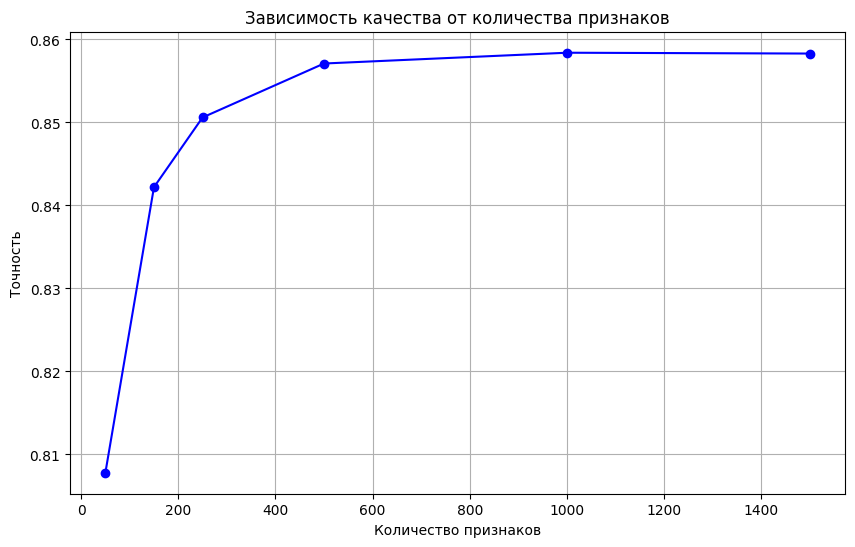

In [57]:
import matplotlib.pyplot as plt


n_features_list = sorted(results_n_features_timing.keys())
accuracies = [results_n_features_timing[n_features][0] for n_features in n_features_list]


plt.figure(figsize=(10, 6))
plt.plot(n_features_list, accuracies, marker='o', linestyle='-', color='b')
plt.title('Зависимость качества от количества признаков')
plt.xlabel('Количество признаков')
plt.ylabel('Точность')
plt.grid(True)
plt.show()


### 3

In [58]:
results_classifiers_timing = {}

for classifier in ['logreg', 'svm']:
    start_time = time.time()
    rff_pipeline = RFFPipeline(n_features=1000, use_PCA=True, classifier=classifier).fit(x_train[subset_idx], y_train[subset_idx])
    training_time = time.time() - start_time
    
    start_time = time.time()
    y_pred = rff_pipeline.predict(x_test)
    prediction_time = time.time() - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    results_classifiers_timing[classifier] = (accuracy, training_time, prediction_time)


for classifier, (accuracy, training_time, prediction_time) in results_classifiers_timing.items():
    print(f'Classifier={classifier}: Accuracy={accuracy}, Training time={training_time:.2f}s, Prediction time={prediction_time:.2f}s')


/Users/maximzabelin/anaconda3/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/maximzabelin/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Classifier=logreg: Accuracy=0.8564, Training time=103.00s, Prediction time=0.32s
Classifier=svm: Accuracy=0.8489, Training time=229.83s, Prediction time=0.29s


### 1

использлование pca увеличивает время обучения, но дает прирост в качестве, а также уменьшает инференс 


### 2

беря все больше и больше признаков мы получаем больше исходной информации и следовательно качество становиться лучше, но после 500 разницы уже практически никакой

### 3


ну тут разницы в качестве практически нет, но есть разница во времени обучения
поэтому луче будет брать логрег

__Задание 4. (Максимум 2 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет). Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.

In [ ]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

__Задание 5. (Максимум 1 балл)__

Поэкспериментируйте с функциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества. Также можете попробовать другой классификатор поверх случайных признаков, сравните результаты.

In [ ]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

__Задание 6. (Максимум 1 балл)__

Реализуйте класс ядровой Ridge регрессии (Лекция 13, $\S 1.2$), для оптимизации используте градиентный спуск, а не аналитическую формулу. Также подумайте о том, как в формулах правильно учесть свободный коэффициент. Затем адаптируйте вашу реализацию RFF под задачу регрессии. Сравните вашу ядровую регрессию и RFF на синтетических данных.

Функция потерь: 
$$
Q(w) = \frac{1}{2} ||\Phi \Phi^T w - y||^2 + \frac{\lambda}{2} w^T \Phi \Phi^T w \rightarrow \min_w,
$$
где $\Phi \Phi^T = K$, $K = (k(x_i, x_j))_{i, j = 1}^{\ell}$.

Предсказание: 
$
y(x) = k(x)^T w,
$
где $k(x)$ — вектор функций ядра от пар объектов $(x, x_i)_{i=1}^{\ell}$.

Вы можете изменять представленный ниже шаблон по своему усмотрению.

In [ ]:
import numpy as np
from sklearn.base import RegressorMixin
from sklearn.gaussian_process.kernels import RBF

class KernelRidgeRegression(RegressorMixin):
    """
    Kernel Ridge regression class
    """

    def __init__(self,         
        lr=0.01,
        regularization=1.,
        tolerance=1e-2,
        max_iter=1000,
        batch_size=64,
        kernel_scale=1.
    ):
        """
        :param lr: learning rate
        :param regularization: regularization coefficient
        :param tolerance: stopping criterion for square of euclidean norm of weight difference
        :param max_iter: stopping criterion for iterations
        :param batch_size: size of the batches used in gradient descent steps
        :parame kernel_scale: length scale in RBF kernel formula
        """

        self.lr: float = lr
        self.regularization: float = regularization
        self.w: np.ndarray | None = None

        self.tolerance: float = tolerance
        self.max_iter: int = max_iter
        self.batch_size: int = batch_size
        self.loss_history: list[float] = []
        self.kernel = RBF(kernel_scale)

    def calc_loss(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculating loss for x and y dataset
        :param x: features array
        :param y: targets array
        """
        raise NotImplementedError

    def calc_grad(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculating gradient for x and y dataset
        :param x: features array
        :param y: targets array
        """
        raise NotImplementedError

    def fit(self, x: np.ndarray, y: np.ndarray) -> "KernelRidgeRegression":
        """
        Fitting weights for x and y dataset
        :param x: features array
        :param y: targets array
        :return: self
        """
        raise NotImplementedError

    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Predicting targets for x dataset
        :param x: features array
        :return: prediction: np.ndarray
        """
        raise NotImplementedError